<a href="https://colab.research.google.com/github/ricglz/CE888_activities/blob/version_2/assignment/Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Normally constant aspects (doesn't require as much config)

## Install dependencies

---

In [1]:
!pip --quiet install torch torchvision patool timm pytorch-lightning

In [2]:
from math import ceil
from os import path, mkdir
from pandas import DataFrame
from patoolib import extract_archive
from sklearn.model_selection import train_test_split
from time import time
from tqdm import tqdm
from zipfile import ZipFile
import matplotlib.pyplot as plt
import random
import seaborn as sns
import sys
import timm

import pytorch_lightning as pl
import pytorch_lightning.callbacks as pl_callbacks
from pytorch_lightning.utilities import xla_device
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.metrics import Accuracy, ConfusionMatrix, \
                                      MetricCollection, F1

from torch import cuda, sigmoid, stack, use_deterministic_algorithms
from torch.nn import BCEWithLogitsLoss, ModuleDict
from torch.nn.modules.batchnorm import _BatchNorm
from torch.optim import Adam, AdamW, RMSprop, SGD
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torch.utils.data.sampler import Sampler

import torchvision.transforms as T
from torchvision.datasets import ImageFolder

## Data setup

---


Before we begin, lets mount the google drive to later on read information from it:

In [3]:
try:
    from google.colab import drive
    in_colab = True
except ImportError:
    in_colab = False

In [4]:
def unzip_file(zip_path, dest_path):
    with ZipFile(zip_path, 'r') as zf:
        for member in tqdm(zf.infolist(), desc='Extracting '):
            zf.extract(member, dest_path)

In [5]:
def unrar_files(tar_dir_path, dest_dir):
    if not path.exists(dest_dir):
        mkdir(dest_dir)
    for dataset in ('Test', 'Training'):
        tar_path = path.join(tar_dir_path, f'{dataset}.tar')
        dest_folder = path.join(dest_dir, dataset)
        if path.exists(dest_folder):
            continue
        mkdir(dest_folder)
        extract_archive(tar_path, outdir=dest_folder)

In [6]:
minified = True

In [7]:
def get_data_dir():
    kaggle_path = '../input/ce888-dataset'
    if path.exists(kaggle_path):
        dest_dir = './data'
        unrar_files(kaggle_path, dest_dir)
        return dest_dir

    general_dir = '.'
    data_dir = general_dir + '/Flame'
    if in_colab and not path.exists(data_dir):
        drive_path = '/content/gdrive'
        drive.mount(drive_path, force_remount=False)
        zip_file = 'Minified-Flame.zip' if minified else 'Flame.zip'
        zip_path = f'MyDrive/Essex/Datasets/zipped/{zip_file}'
        unzip_file(path.join(drive_path, zip_path), general_dir)
    return data_dir

In [8]:
def get_model_dir():
    return './Models'
    return '/content/gdrive/MyDrive/Models/Lightning' if in_colab \
           else './Models'

## Seed

---

In [9]:
seed = 42
pl.seed_everything(seed)

Global seed set to 42


42

## Datamodule preparation

----

A datamodule is a module that provides us _lightning_ to be able to structure our datadependencies in a more modular way

In this case we will also declare transformations like the resize and the normalization. The normalization used are [the mean and std of the ImageNet dataset](https://github.com/rwightman/pytorch-image-models/blob/master/timm/data/constants.py)

### Helper classes

In [10]:
class BalancedBatchSampler(Sampler):
    """
    Inspired by:
    https://github.com/galatolofederico/pytorch-balanced-batch/blob/master/sampler.py
    """
    def __init__(self, dataset, shuffle=False):
        super().__init__(None)
        self.dataset = dict()
        real_dataset = dataset
        while hasattr(real_dataset, 'dataset'):
            real_dataset = real_dataset.dataset
        self.balanced_max = 0
        self.shuffle = shuffle
        # Save all the indices for all the classes
        for idx in range(0, len(dataset)):
            label = self._get_label(real_dataset, idx)
            if label not in self.dataset:
                self.dataset[label] = list()
            self.dataset[label].append(idx)
            self.balanced_max = max(len(self.dataset[label]), self.balanced_max)

        # Oversample the classes with fewer elements than the max
        for label in self.dataset:
            while len(self.dataset[label]) < self.balanced_max:
                self.dataset[label].append(random.choice(self.dataset[label]))
        self.keys = list(self.dataset.keys())
        self.current_key = 0
        self.indices = [-1]*len(self.keys)

    @staticmethod
    def _get_label(dataset, idx):
        return dataset.imgs[idx][1]

    def __len__(self):
        return self.balanced_max*len(self.keys)

    def __iter__(self):
        if self.shuffle:
            for key in self.keys:
                random.shuffle(self.dataset[key])
        while self.indices[self.current_key] < self.balanced_max - 1:
            self.indices[self.current_key] += 1
            label = self.keys[self.current_key]
            index_label = self.indices[self.current_key]
            yield self.dataset[label][index_label]
            self.current_key = (self.current_key + 1) % len(self.keys)
        self.indices = [-1]*len(self.keys)

### DataModule

In [11]:
DEFAULT_BATCH_SIZE = 32
DEFAULT_IMAGE_SIZE = (224, 224)
STEPS = 1198 if minified else 2397

class FlameDataModule(pl.LightningDataModule):
    def __init__(
            self,
            batch_size=DEFAULT_BATCH_SIZE,
            image_size=DEFAULT_IMAGE_SIZE
        ):
        super().__init__()
        self.batch_size = batch_size
        resize = T.Resize(image_size)
        normalize = T.Normalize([0.485, 0.456, 0.406], 
                                [0.229, 0.224, 0.225])
        toTensor = T.ToTensor()
        self.train_transforms = T.Compose([
            resize,
            T.ColorJitter(brightness=0.1, contrast=0.1),
            T.RandomRotation(degrees=45),
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            toTensor,
            normalize
        ])
        self.transforms = T.Compose([resize, toTensor, normalize])

    def prepare_data(self):
        self.data_dir = get_data_dir()
    
    def create_dataset(self, folder_name, transforms):
        return ImageFolder(path.join(self.data_dir, folder_name), transforms)

    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            self.train_ds = self.create_dataset('Training', self.train_transforms)
            self.val_ds = self.create_dataset('Validation', self.transforms)
        if stage == 'test' or stage is None:
            self.test_ds = self.create_dataset('Test', self.transforms)

    def _general_dataloader(self, dataset, **kwargs):
        return DataLoader(
            dataset, batch_size=self.batch_size, num_workers=2, drop_last=True,
            pin_memory=True, **kwargs)

    def train_dataloader(self):
        sampler = BalancedBatchSampler(self.train_ds, shuffle=True)
        return self._general_dataloader(self.train_ds, sampler=sampler)
        # print(len(loader))
        # return loader

    def val_dataloader(self):
        return self._general_dataloader(self.val_ds)

    def test_dataloader(self):
        return self._general_dataloader(self.test_ds)

In [12]:
datamodule = FlameDataModule()

# Model 

---

In [25]:
class PretrainedModel(pl.LightningModule):
    def __init__(
        self, name='rexnet_200', epochs=10, steps_per_epoch=100, lr=1e-3,
        drop_rate=0.5, max_momentum=0.95
    ):
        super().__init__()

        self.save_hyperparameters()
        self.model = timm.create_model(name, pretrained=True,
                                       num_classes=1, drop_rate=drop_rate)
        self.just_train_classifier()

        self.criterion = BCEWithLogitsLoss()
        self.metrics = self.build_metrics()
        self.transform = T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip()
        ])
    
    def just_train_classifier(self):
        self.freeze()
        Freezer.make_trainable(self.model.get_classifier())

    @staticmethod
    def build_metrics():
        general_metrics = [
            Accuracy(compute_on_step=False),
            F1(num_classes=2, compute_on_step=False)
        ]
        metric = MetricCollection(general_metrics)
        return ModuleDict({
            'test_metrics': metric.clone(),
            'train_metrics': metric.clone(),
            'val_metrics': metric.clone(),
        })

    def forward(self, x, tta = 0):
        if tta == 0:
            return self.model(x).squeeze(-1)
        y_hat_stack = stack([self(self.transform(x)) for _ in range(tta)])
        return y_hat_stack.mean(dim=0)
    
    def predict(self, x):
        proba = sigmoid(self(x))
        return (proba > 0.5).byte()

    # Configurations
    def configure_optimizers(self):
        parameters = filter(lambda p: p.requires_grad, self.parameters())
        optimizer = Adam(parameters, self.hparams.lr, weight_decay=1e-2)
        # optimizer = Lookahead(optimizer)
        scheduler = self._build_scheduler(optimizer)
        scheduler_dict = {'scheduler': scheduler, 'interval': 'step'}
        return [optimizer], [scheduler_dict]
    
    def _build_scheduler(self, optimizer):
        lr, epochs = self.hparams.lr, self.hparams.epochs
        max_momentum = self.hparams.max_momentum
        base_momentum = max_momentum - 0.1
        total_steps = epochs * self.hparams.steps_per_epoch
        div_factor = epochs * 4
        return OneCycleLR(
            optimizer, lr, total_steps, pct_start=0.55, div_factor=div_factor,
            final_div_factor=div_factor, three_phase=True,
            max_momentum=max_momentum, base_momentum=base_momentum)

    # Steps
    def _get_dataset_metrics(self, dataset):
        return self.metrics[f'{dataset}_metrics']

    def _update_metrics(self, y_hat, y, dataset):
        proba = sigmoid(y_hat)
        self._get_dataset_metrics(dataset).update(proba, y)

    def _on_step(self, batch, dataset):
        x, y = batch
        tta = 10 if dataset == 'test' else 0
        y_hat = self(x, tta)
        loss = self.criterion(y_hat, y.float())
        self._update_metrics(y_hat, y, dataset)
        self.log(f'{dataset}_loss', loss, prog_bar=True)
        return loss

    def _on_end_epochs(self, outputs, dataset):
        labels = [f'{dataset}_acc', f'{dataset}_f1']
        metrics = self._get_dataset_metrics(dataset)
        metrics_values = metrics.compute().values()
        for label, value in zip(labels, metrics_values):
            self.log(label, value)
        if dataset != 'train':
            score = stack(list(metrics_values)).mean()
            self.log(f'{dataset}_score', score, prog_bar=True)
        metrics.reset()

    def training_step(self, batch, batch_idx):
        return self._on_step(batch, 'train')
    
    def training_epoch_end(self, outputs):
        self._on_end_epochs(outputs, 'train')
    
    def validation_step(self, batch, batch_idx):
        return self._on_step(batch, 'val')

    def validation_epoch_end(self, outputs):
        self._on_end_epochs(outputs, 'val')

    def test_step(self, batch, batch_idx):
        return self._on_step(batch, 'test')

    def test_epoch_end(self, outputs):
        self._on_end_epochs(outputs, 'test')

# Callbacks

---

## Freezer class

In [14]:
class Freezer(pl_callbacks.BaseFinetuning):
    trainable_layers = []

    def __init__(
        self, steps=4, unfreeze_per_step=8, train_bn=False, epochs=40
    ):
        self.step_size = ceil(epochs / (steps + 1))
        self.unfreeze_per_step = unfreeze_per_step
        self.train_bn = train_bn

    @staticmethod
    def flatten_children(module):
        vanilla_children = list(module.children())
        if len(vanilla_children) == 0:
            return [module]
        children = []
        for child in vanilla_children:
            child_children = Freezer.flatten_children(child)
            children += child_children
        return children

    @staticmethod
    def filter_non_trainable(children):
        calc_num_params = lambda module: sum(p.numel() for p in module.parameters())
        has_params = lambda module: calc_num_params(module) > 0
        return list(filter(has_params, children))
    
    @staticmethod
    def filter_non_frozen(children):
        requires_grad = lambda p: p.requires_grad
        is_frozen_module = \
            lambda module: len(list(filter(requires_grad, module.parameters()))) == 0
        return list(filter(is_frozen_module, children))

    @staticmethod
    def trainable_children(pl_module, train_bn=False, reverse=False):
        children = Freezer.flatten_children(pl_module)
        children = Freezer.filter_non_trainable(children)
        children = Freezer.filter_non_frozen(children)
        if not train_bn:
            is_not_bn = lambda mod: not isinstance(mod, _BatchNorm) 
            children = list(filter(is_not_bn, children))
        if reverse:
            children.reverse()
        return children
    
    def freeze_before_training(self, pl_module):
        self.trainable_layers = self.trainable_children(
            pl_module, self.train_bn, reverse=True)
    
    def finetune_function(self, pl_module, current_epoch, optimizer, optimizer_idx):
        trainable_layers_len = len(self.trainable_layers)
        is_empty = trainable_layers_len == 0
        is_finetune_epoch = current_epoch % self.step_size == 0 and \
                         current_epoch != 0
        if not is_finetune_epoch or is_empty:
            return
        to_be_trained_layers = []
        layers_to_be_freeze = min(self.unfreeze_per_step, trainable_layers_len)
        for _ in range(layers_to_be_freeze):
            to_be_trained_layers.append(self.trainable_layers.pop(0))
        self.unfreeze_and_add_param_group(
            to_be_trained_layers, optimizer, swa=True, one_cycle=True)

    @staticmethod
    def unfreeze_and_add_param_group(
        modules,
        optimizer,
        swa = False,
        one_cycle = False,
        lr = None,
        initial_denom_lr = 10.,
        train_bn = True,
    ):
        Freezer.make_trainable(modules)
        params_lr = optimizer.param_groups[0]['lr'] if lr is None else float(lr)
        denom_lr = initial_denom_lr if lr is None else 1.
        initial_lr = params_lr / denom_lr
        params = Freezer.filter_params(modules, train_bn=train_bn, requires_grad=True)
        params = Freezer.filter_on_optimizer(optimizer, params)
        if params:
            param_group = {
                'params': params, 'lr': initial_lr, 'initial_lr': initial_lr,
            }
            extra_data = {}
            if one_cycle:
                extra_data = Freezer.momentum_param_group(optimizer)
            if swa:
                extra_data = { 'swa_lr': initial_lr, **extra_data }
            param_group = { **param_group, **extra_data }
            optimizer.add_param_group(param_group)

    @staticmethod
    def momentum_param_group(optimizer):
        group = optimizer.param_groups[0]
        momentum_group = {
            'base_momentum': group['base_momentum'],
            'max_momentum': group['max_momentum'],
            'max_lr': group['max_lr'],
            'min_lr': group['min_lr'],
        }
        extra_group = {
            'betas': group['betas']
        } if 'betas' in optimizer.defaults else {
            'momentum': group['momentum']
        }
        return { **momentum_group, **extra_group }

## ProgressBar class

In [15]:
class ProgressBar(pl_callbacks.ProgressBarBase):
    def __init__(self):
        super().__init__()
        self.epoch_time = 0
        self.stage_time = 0
    
    def disable(self):
        pass
    
    def enable(self):
        pass

    @staticmethod
    def format_num(n) -> str:
        """ Add additional padding to the formatted numbers """
        should_be_padded = isinstance(n, (float, str))
        if not isinstance(n, str):
            n = tqdm.format_num(n)
        if should_be_padded and 'e' not in n:
            if '.' not in n and len(n) < 5:
                try:
                    _ = float(n)
                except ValueError:
                    return n
                n += '.'
            n += "0" * (5 - len(n))
        return n
    
    def get_formatted_duration(self, prev_time):
        duration = time() - prev_time
        if duration < 60:
            unit = 's'
        elif duration < 3600:
            duration /= 60
            unit = 'm'
        else:
            duration /= 3600
            unit = 'h'
        return self.format_num(duration) + unit
    
    def on_train_start(self, trainer, pl_module):
        self.stage_time = time()
        print('Start training')

    def on_train_end(self, trainer, pl_module):
        print(f'Total duration: {self.get_formatted_duration(self.stage_time)}')
    
    def on_train_epoch_start(self, trainer, pl_module):
        self.epoch_time = time()
    
    def on_validation_epoch_end(self, trainer, pl_module):
        values = [
            f'Epoch: {trainer.current_epoch}',
            f'Time: {self.get_formatted_duration(self.epoch_time)}'
        ]
        values += [
            f'{key}: {self.format_num(value)}'
            for key, value in trainer.progress_bar_dict.items()
        ]
        print(' - '.join(values))

## Helper functions

In [16]:
def get_checkpoint(model_name):
    filename = '{epoch:02d}-{val_score:.4f}'
    production_dirpath = path.join(get_model_dir(), model_name)
    dirpath = production_dirpath if production_mode else model_name
    return pl_callbacks.ModelCheckpoint(
        dirpath=dirpath, monitor='val_score', mode='max', filename=filename)

In [17]:
def get_callbacks(model_name, epochs):
    checkpoint = get_checkpoint(model_name)
    freezer = Freezer(epochs=epochs)
    progress_bar = ProgressBar()
    return [checkpoint, freezer, progress_bar]

# Trainer

---

In [18]:
def get_accelerator():
    tpu_device_exists = xla_device.XLADeviceUtils().tpu_device_exists()
    has_gpu = cuda.is_available()

    return {'tpu_cores': 8} if tpu_device_exists else \
           {'gpus': cuda.device_count()} if has_gpu else {}

In [19]:
max_epochs = 5
production_mode = True

def create_trainer(model_name, **kwargs):
    callbacks = get_callbacks(model_name, max_epochs)
    accelerator = get_accelerator()
    return pl.Trainer(
        max_epochs=max_epochs, deterministic=True, benchmark=True,
        callbacks=callbacks, precision=16, stochastic_weight_avg=False,
        **accelerator, **kwargs)

# Tuning

---

In [20]:
def find_best_and_substitute_lr(model, **kwargs):
    trainer = create_trainer(model.hparams.name, auto_lr_find=True, **kwargs)
    if trainer.fast_dev_run:
        return
    lr_finder = trainer.tuner.lr_find(
        model, min_lr=1e-4, max_lr=9e-2, datamodule=datamodule,
        num_training=480)
    lr_finder.plot(suggest=True, show=True)
    suggest_lr = lr_finder.results['lr'][lr_finder._optimal_idx]
    model.hparams.lr = suggest_lr

# Training and testing

---

In [21]:
def create_fit_and_test(model_name, **kwargs):
    model = PretrainedModel(model_name, max_epochs, STEPS)
    find_best_and_substitute_lr(model, **kwargs)
    print(f'Training with max lr of {model.hparams.lr:.2e}')
    trainer = create_trainer(model.hparams.name, **kwargs)
    trainer.fit(model, datamodule=datamodule)
    trainer.test(model, datamodule=datamodule)
    cuda.empty_cache()

# Models results

---

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
Using native 16bit precision.

  | Name      | Type              | Params
------------------------------------------------
0 | model     | ByobNet           | 18.6 M
1 | criterion | BCEWithLogitsLoss | 0     
2 | metrics   | ModuleDict        | 0     
------------------------------------------------
2.6 K     Trainable params
18.6 M    Non-trainable params
18.6 M    Total params
74.338    Total estimated model params size (MB)


Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt


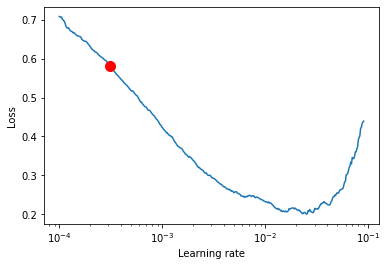

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
Using native 16bit precision.

  | Name      | Type              | Params
------------------------------------------------
0 | model     | ByobNet           | 18.6 M
1 | criterion | BCEWithLogitsLoss | 0     
2 | metrics   | ModuleDict        | 0     
------------------------------------------------
2.6 K     Trainable params
18.6 M    Non-trainable params
18.6 M    Total params
74.338    Total estimated model params size (MB)


Training with max lr of 3.12e-04
Epoch: 0 - Time: 4.49e+5h - loss: nan.0 - v_num: 4 - val_loss: 0.749 - val_score: 0.0781
Start training
Epoch: 0 - Time: 2.250m - loss: 0.381 - v_num: 4 - val_loss: 0.391 - val_score: 0.895 - train_loss: 0.302
Epoch: 1 - Time: 2.280m - loss: 0.0592 - v_num: 4 - val_loss: 0.0806 - val_score: 0.977 - train_loss: 0.00832
Epoch: 2 - Time: 2.330m - loss: 0.080 - v_num: 4 - val_loss: 0.120 - val_score: 0.960 - train_loss: 0.0685
Epoch: 3 - Time: 2.380m - loss: 0.0755 - v_num: 4 - val_loss: 0.104 - val_score: 0.960 - train_loss: 0.0344
Epoch: 4 - Time: 2.420m - loss: 0.0727 - v_num: 4 - val_loss: 0.0721 - val_score: 0.977 - train_loss: 0.425
Total duration: 11.70m
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.7876393795013428,
 'test_f1': 0.7043028473854065,
 'test_loss': 0.6329432129859924,
 'test_score': 0.7459710836410522}
------------------------------------------------------------

In [26]:
create_fit_and_test('gernet_m')

In [ ]:
create_fit_and_test('repvgg_b0')

In [ ]:
create_fit_and_test('rexnet_200')

In [ ]:
create_fit_and_test('tf_efficientnet_b4')

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir /content/lightning_logs

In [ ]:
# !mv /content/lightning_logs /content/gdrive/MyDrive/Models/logs